# 텐서플로우의 패션 MNIST데이터 셋

In [2]:
from tensorflow import keras
(x_train,y_train),(x_test,y_test)=keras.datasets.fashion_mnist.load_data()

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [3]:
x_train.shape   # 28*28배열 6만개 x데이터셋

(60000, 28, 28)

In [4]:
print(x_train.min(),x_train.max())  # 0~255값

0 255


In [5]:
print(y_train.shape, y_train.min(), y_train.max())  #숫자0~9중 하나인 y데이터셋 6만개

(60000,) 0 9


In [6]:
x_test.shape, y_test.shape   #테스트셋은 만개

((10000, 28, 28), (10000,))

In [7]:
import numpy as np
np.save('fmnist_x_train.npy',x_train)
np.save('fmnist_y_train.npy',y_train)
np.save('fmnist_x_test.npy',x_test)
np.save('fmnist_y_test.npy',y_test)

## 이미지로 보기

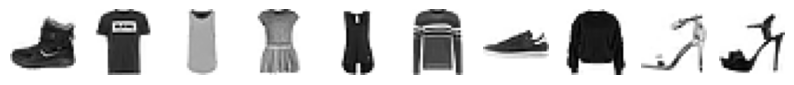

In [8]:
import matplotlib.pyplot as plt
fig, axes=plt.subplots(1,10,figsize=(10,10))
for i in range(10):
    axes[i].imshow(x_train[i],cmap='gray_r')
    axes[i].axis('off')
plt.show()

In [9]:
# 정답
y_train[:10]

array([9, 0, 0, 3, 0, 2, 7, 2, 5, 5], dtype=uint8)

### y값
0:티셔츠  1:바지  2:스웨터  3:드레스  4:코트  5:샌달  6:셔츠  7:스니커즈  8:가방  9:앵클부츠

In [10]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

# 0. 로지스틱 회귀로 분류
- 확률적 경사하강법(SGDClassifier)

### 정규화
- 스케일화 후 reshape

In [11]:
x_train=x_train/255
x_train=x_train.reshape(-1,28*28)   # 28*28의 2차원을 784,의 1차원으로
x_train.shape

(60000, 784)

In [12]:
from sklearn.model_selection import cross_validate
from sklearn.linear_model import SGDClassifier
sc=SGDClassifier(loss='log_loss',max_iter=5,random_state=123)
scores=cross_validate(sc,x_train,y_train,n_jobs=-1)
print(np.mean(scores['test_score']))

0.80335


## 해석: 784개의 모든 픽셀의 coef_값과 하나의 intercept를 가지는 선형방정식을 10개의 옷종류 모두에 대해 구함. 그리고 모든 10종류에 대해 시행한 다음 소프트맥스 함수에 통과시켜 각 클래스(10가지 옷종류)에 대한 확률을 얻어 이중 가장 큰 확률값을 가지는 애를 클래스(옷종류)로 지정
## max_iter값을 늘려도 성는이 크게 늘지 않음

# 1.인공신경망ANN(artificial neural network)
### 신경망은 층 개수만큼의 선형계산의 반복
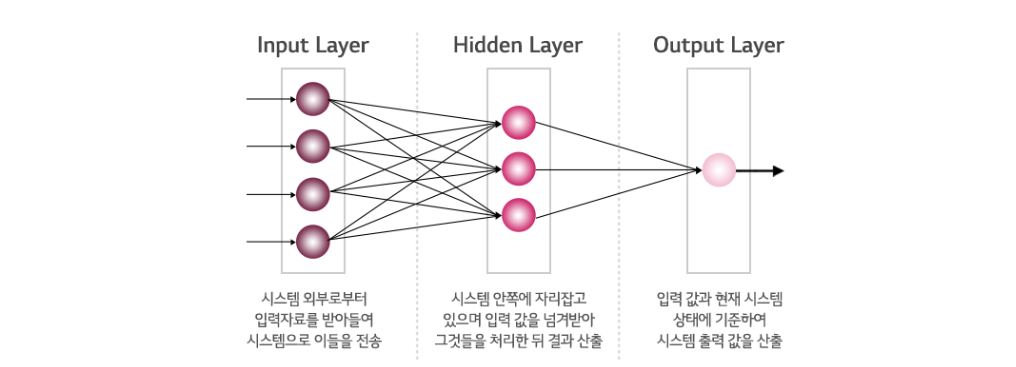  
- 은닉층: 입력 데이터로부터 패턴을 학습하는 계층이다. 은닉층은 여러 개가 될 수 있고, 층이 깊어질수록 모델은 더 복잡한 특징을 학습할 수 있다.  
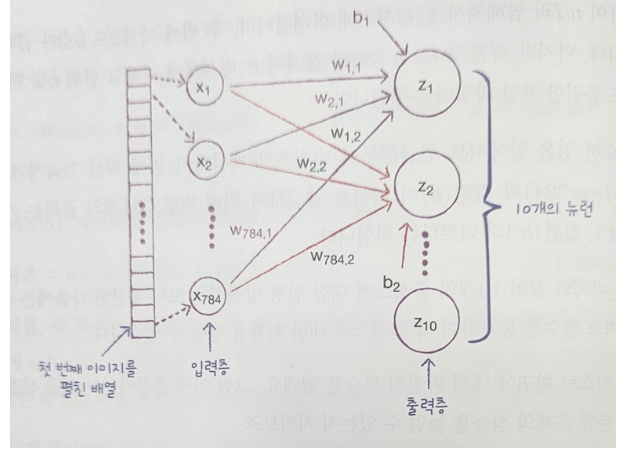  
- 입력층 x1-x784, 출력층(유닛 or 뉴런) z1-z10, 가중치 w(1,1), w(1,2),-w(1,10), w(2,1)-w(2,10),...-...w(784,9),w(784,10),  절편b1-b10
- z1을 만들기 위해 x1*w(1,1)+x2*w(2,1)+...+x784*w(784,1)+b1
- z2을 만들기 위해 x1*w(1,2)+x2*w(2,2)+...+x784*w(784,2)+b2
- z10을 만들기 위해 x1*w(1,10)+x2*w(2,10)+...+x784*w(784,10)+b10  
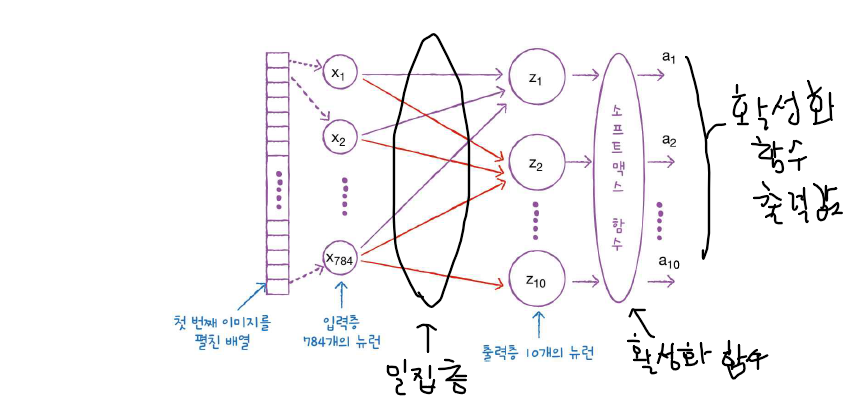  
- 가운데의 수도없이 많은 선들이 밀집층  
- 뉴런의 선형방정식 계산 결과에 활성화 함수를 적용시켜 a1~a10의 값이 출력
- 밀집층: 모든 뉴런이 서로 연결된 층(구조의 개념)
- 은닉층: 입력층과 출력층 사이에 있는 층(역할의 개념)
- 가능한 은닉층 종류:밀집층(Dense layer), 합성곱층(Convolutional layer), 순환층(RNN), 정규화층(BatchNorm) 등등
- 그래서 밀집층이 은닉층일 수도 있고 아닐 수도 있음!

### 출력층에 적용할 수 있는 활성화 함수 종류는 제한적
- 이진분류일 경우 시그모이드 함수
- 다중 분류일경우 소프트맥스 함수 적용

In [13]:
import tensorflow as tf
from tensorflow import keras

## 1-1.인공신경망에서는 머신러닝처럼 교차검증을 잘 사용하지 않고 검증세트를 별도로 덜어내어 사용
- 딥러닝분야의 데이터셋은 충분히 커 검증점수가 안정적이고 교차검증 수행하기에 시간이 너무 오래걸려서

In [14]:
# 검증세트 덜기
from sklearn.model_selection import train_test_split
# 이미 전처리 된 애들 사용
x_train,x_validation,y_train,y_validation=train_test_split(x_train,y_train,test_size=0.2,random_state=123)

print(x_train.shape,y_train.shape)
print(x_validation.shape,y_validation.shape)   #12000개가 검증세트

(48000, 784) (48000,)
(12000, 784) (12000,)


### 48000개의 훈련세트로 모델을 만들고 12000개의 검증세트로 평가

## 1-2. 밀집층 만들기
- keras.layers패키지 안에는 다양한 층이 준비되어 있음
- keras.layers.Dense(뉴런개수,activation=활성화함수,input_shape=입력의 크기)

In [15]:
dense=keras.layers.Dense(10,activation='softmax',input_shape=(784,)) #뉴런(분류할 클래스)10개, 활성화함수=softmax->출력값을 확률로 바꾸기 위해, 입력크기=(784,)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


## 1-3. 모델 만들기
- keras.Sequential(밀집층)

In [16]:
model=keras.Sequential([dense])  #dense라는 밀집층을 가진 모델 생성/ 리스트나 튜플 형태로 넣어줌

## 1-4. 모델 환경설정
- model.compile(손실함수, 계산하고 싶은 측정값유형)

In [17]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy']) # 크로스엔트로피 손실함수, 정확도를 사용하겠다/ metrics에는 리스트나 튜플형태로

### 손실함수: 예측한 값과 실제 값 사이의 차이를 측정하는 함수
### 종류: MSE, MAE, cross_entropy(binary/categorical/sparse-categorical)
- 정답 클래스에 대해 확률을 높게 예측할수록 손실은 낮아지고, 낮게 예측할수록 손실은 커짐
- 이진분류: binary_crossentropy사용->뉴런이 하나뿐이므로 양성일 확률을 a라하면 음성일 확률은 자동으로 1-a라고 구할수있음  
타깃값=1(양성)일때의 '크로스 엔트로피화'->a에 -log(a)*타깃값(1) 적용시키는것   
타깃값=0(음성)일때의 '크로스 엔트로피화'->a에 -log(1-a)*(1-타깃값=1) 적용시키는것
- 다중분류: categorical_crossentropy  
- 크로스엔트로피화: 활성화 함수에 의한 a에 대해 -log(a)*타깃값 적용시키는것  
 *정답 레이블이 one-hot encoding이면 그대로 categorical_crossentropy사용  
 *정답 레이블이 정수형태면 sparse_categorical_crossentropy사용    
모든 뉴런에 대한 확률을 출력하게 되며 이중 적절하다고 판단되는 타깃의 확률값만 남기고 나머지 확률에는 모두 0을 곱함  
ex) 3번째 클래스가 정답일 경우 활성화 함수의 출력값들인 a들에 대해 [a1,a2,a3,..,a9,a10] X [0,0,1,0,0,0,0,0,0,0]를 진행하게 됨(원-핫 인코딩화)  
그리고 하나만 남은 a값은 1에 가까워야 좋으며 이 a에 크로스엔트로피를 적용시킴(적용시 0에 가까워 질수록 손실이 낮아짐)  
- 주의할점: sparse에서 -log(a)*타깃값자체의 식은 맞지만 실제로 타깃값은 곱해주지 않음->실제 엔트로피화:-log(a)
### 예시: 타깃값=[0,0,1,0] or 2 이고 그 때의 타깃값 확률을 a라 한다면 둘다 결국 엔트로피화 값은 -log(a)



## 1-5. 학습
- model.fit(x,y,반복횟수)

In [18]:
model.fit(x_train,y_train,epochs=5)  #반복 횟수별 시간과 손실, 그리고 우리가 metrics에서 설정한 accuracy가 추가로 출력

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7360 - loss: 0.7837
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8367 - loss: 0.4817
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8468 - loss: 0.4525
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8505 - loss: 0.4447
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8542 - loss: 0.4318


## 1-6. 모델 성능평가
- model.evaluate(x,y)

In [19]:
model.evaluate(x_validation,y_validation)  # .fit과 비슷하게 출력 ->85퍼의 정확도

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8616 - loss: 0.4228


[0.43569132685661316, 0.8565833568572998]

# 2. 심층신경망DNN(deep neural network)
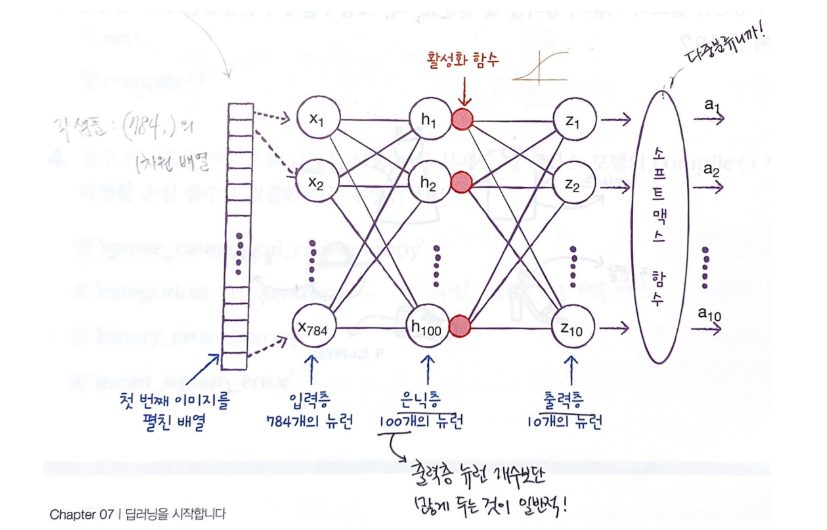
- 은닉층= 입력층과 출력층 사이에 있는 모든 층
- 새로 삽입된 방정식에 의해 출력된 은닉층뉴런에는 활성화 함수가 적용됨  
이유: 활성화 함수가 없으면 a=b, b=c->a=c가 되므로 역할이 없어지는 셈. a=b -> log(b) -> log(b)=c하여 비틀어주면서 b가 의미를 가지게함
- 출력층에 비해 은닉층의 활성화함수 종류는 자유로움(시그모이드, 렐루 등)

## 은닉층의 활성화 함수
### 1. 시그모이드 함수
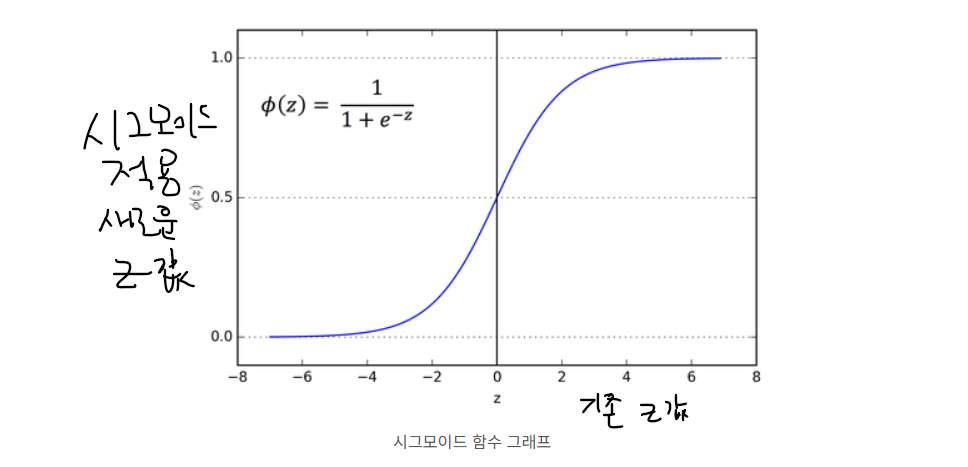
- 뉴런의 출력 z값을 0과 1사이로 압축
- 단점: 출력값(z)이 너무 크거나 작을 땐 함수적용값의 차이가 너무 미미함 → 변화에 빠르게 대응하지 못하니까 결국 층을 깊게 쌓기가 힘듦.

### 2. 렐루함수(ReLU)
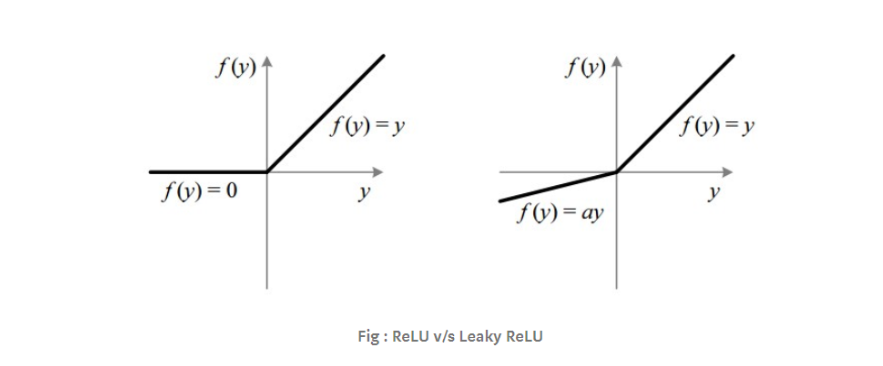
- z가 0보다 크면 z를 그대로 출력 vs z가 0보다 작으면 전부 0으로 출력
- 신경망은 선형 계산의 반복->이것만 반복하면 결국 선형모델이어서 복잡한 학습이 불가->0이하값을 0으로 만들어서 비선형성 특성을 줘서 복잡하게
- 그렇다면 왜 선형방정식 값이 음수면 의미없는 값일 확률이 높을까?  
 y=ax+b와 같은 값이 음수가 나오면 가중치와 입력을 계산했을 때, 강하게 활성화되는 조건이 아니었다는 뜻 -> 뉴런이 별로 중요한 반응을 안하네
- 0을 아예무시하기 그러니 대안책들도 있음: Leaky ReLU, ELU, Swish 같은 함수들: 음수도 조금은 반영해서 dying ReLU 문제를 피함  
ex) leaky relu의 경우 z값이 0이하일때 0.01z값을 출력

# 2-1. 여러 층 만들기

In [20]:
dense1=keras.layers.Dense(100,activation='sigmoid',input_shape=(784,),name='hidden')  #뉴런 개수는 정해진 기준은 없음(최소 출력층보다 많아야 함)->경험으로 판단
dense2=keras.layers.Dense(10,activation='softmax',name='output') #두번째 층 이후부터는 input_shape안정해줘도 됨(케라스가 자동으로 추론)

# 2-2. 심층신경망 만들기
- 앞쪽 층을 리스트의 앞에, 출력층을 맨 마지막에

In [21]:
model=keras.Sequential([dense1,dense2],name='fashion_mnist_model')

### (층을 추가하는 다른 방법들)

In [22]:
# 층을 추가하는 다른 방법들
# 1.
model=keras.Sequential([keras.layers.Dense(100,activation='sigmoid',input_shape=(784,),name='hidden'),
                        keras.layers.Dense(10,activation='softmax',name='output'),
                        ],name='fashion_mnist_model')

# 2.
model=keras.Sequential(name='fashion_mnist_model')
model.add(keras.layers.Dense(100,activation='sigmoid',input_shape=(784,),name='hidden'))
model.add(keras.layers.Dense(10,activation='softmax',name='output'))

# 2-3. summary()로 정보
- 모델 이름->집어넣은 층(층 이름) 순서대로 정보
- output shape: (none,n)-> n이 뉴런의 개수. 첫번째 차원은 샘플개수: none인 이유는 경사하강법을 위해 샘플수를 고정하지않고 유연하게 하기위해
- param: 파라미터 개수 ex) 784*100(각 뉴런층에 따른 각 입력층에 따른 가중치 개수)+100(출력층100개이므로 절편도 100개)=78500

In [23]:
model.summary()

Model: "fashion_mnist_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden (Dense)                  │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

# 2-4. 환경설정 후 모델 훈련

In [24]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.7421 - loss: 0.7889
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8458 - loss: 0.4252
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8624 - loss: 0.3731
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8692 - loss: 0.3558
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8769 - loss: 0.3365


# 2-5. 평가

In [25]:
model.evaluate(x_validation,y_validation)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8681 - loss: 0.3624


[0.3715321719646454, 0.8671666383743286]

# !! 렐루함수 + flatten층 사용버전 !!
- reshape없이 keras에서 자동으로 1차원으로 펼처줌


In [26]:
#스케일화만
(x_train,y_train),(x_test,y_test)=keras.datasets.fashion_mnist.load_data()
x_train=x_train/255  #스케일화
x_train,x_val,y_train,y_val=train_test_split(x_train,y_train,test_size=0.2,random_state=123)

# 렐루로 모델+층 생성
model=keras.Sequential()
model.add(keras.layers.Flatten(input_shape=(28,28)))  # 28*28로 입력받아 flatten층을 거쳐 1차원으로
model.add(keras.layers.Dense(100,activation='relu',name='hidden'))  #acitvation=relu,  flatten층 있어서 input_shape필요X
model.add(keras.layers.Dense(10,activation='softmax',name='output'))

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden (Dense)                  │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [27]:
# 모델 환경설정+학습
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'])
model.fit(x_train,y_train,epochs=5)    #렐루가 좀더 정확

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7652 - loss: 0.6767
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8555 - loss: 0.4045
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8721 - loss: 0.3577
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8801 - loss: 0.3305
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8867 - loss: 0.3222


In [28]:
model.evaluate(x_val,y_val)  #얘네 넣을때도 reshape필요X

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8867 - loss: 0.3197


[0.33004099130630493, 0.8828333616256714]

# 2-6. 옵티마이저: 신경망에서의 하이퍼파라미터
- 종류: 은닉층의 개수, 은닉층의 뉴런개수, 활성화함수, 층 종류, .fit()의 batch_szie, epochs, .compile()안의 파라미터들, 학습률


### .compile()의 sgd(경사하강법) 옵티마이저
- learning_rate(기본값 0.01): 학습률: 딥러닝 학습에서는 손실 함수(loss)를 줄이기 위해 가중치(w)를 계속 바꿈 -> 이때 경사(gradient)를 따라 이동하는데, 학습률은 이걸 얼마나 "크게" 움직일지 결정함.  
> 손실 함수의 기울기(gradient)를 보고 w를 업데이트할 때 곱하는 값!  
> 학습률이 너무 크면: 한 번에 너무 크게 점프함 → 최솟값을 지나치고 손실이 발산할 수 있음  
> 학습률이 너무 작으면: 이동 폭이 너무 작아서 학습이 매우 느리고, local minimum에 갇힐 수 있음  
> 어느정도가 적당한지는 직접 실험해볼 수 밖에 없음
- momentum(기본값 0): 값 지정 시 이전 그레디언트를 가속도 처럼(기울기를 누적해서 관성처럼 이동) 사용하는 모멘텀 최적화 사용   
> 진동은 줄이고 중요한 방향으로 빠르게 수렴 가능케 함
- nesterov(기본값 False): True시 네스테로프 모멘텀(그냥 모멘텀보다 더 똑똑한 버전) 최적화 사용
> 먼저 예측 위치로 한 발짝 가본 다음, 거기서의 기울기를 보는 전략(이 방향으로 가면 어떻게 될지 미리 한 번 살펴보고 가자)-> 더 빠르고 안정적

In [29]:
sgd=keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=True)
model.compile(optimizer=sgd,            #여기 옵티마이저에 위의 sgd값 넣어 설정
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

### .compile()의 적응적 학습률(adaptive learning rate) -> 모델이 최적점에 가까워질수록 학습률을 낮춤
- adagrad or RMSprop  
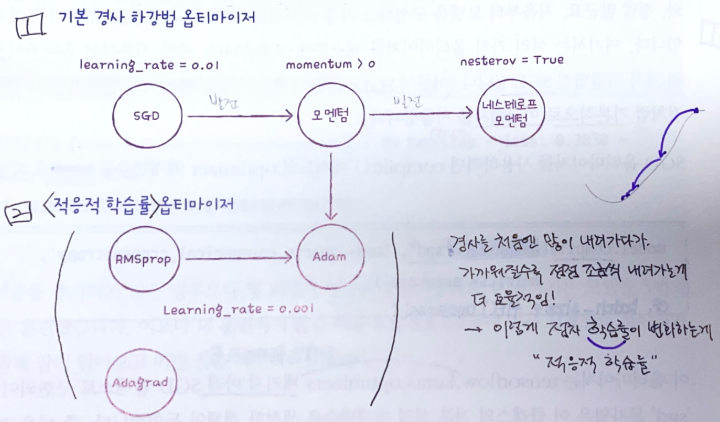

In [30]:
adagrad=keras.optimizers.Adagrad()
rmsprop=keras.optimizers.RMSprop()

model.compile(optimizer=adagrad) or model.compile(optimizer=rmsprop)

# .compile()에 옵티마이저는 딱 하나만 쓸 수 있음
- adam: 모멘텀 최적화와 RMSprop의 장점을 접목한 옵티마이저

# 최종버전

In [31]:
model=keras.Sequential()

model.add(keras.layers.Flatten(input_shape=(28,28)))
model.add(keras.layers.Dense(100,activation='relu',name='hidden'))
model.add(keras.layers.Dense(10,activation='softmax',name='output'))

model.compile(optimizer='adam',            #여기 옵티마이저에 위의 'adam값 넣어 설정
              loss='sparse_categorical_crossentropy',metrics=['accuracy'])

model.fit(x_train,y_train,epochs=5)

Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.7726 - loss: 0.6619
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8539 - loss: 0.4084
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.8727 - loss: 0.3548
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.8794 - loss: 0.3323
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8858 - loss: 0.3094


In [32]:
model.evaluate(x_val,y_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8952 - loss: 0.3055


[0.31743139028549194, 0.890666663646698]

# 예측

In [33]:
prediction=model.predict(x_test[0:5])
prediction

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 377ms/step


array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0.]], dtype=float32)

In [34]:
print(np.argmax(prediction, axis=1), y_test[0:5])

[9 2 1 1 6] [9 2 1 1 6]


# 3. 신경망 모델 훈련을 위한 다양한 도구들

## 3-1. 손실곡선/정확도곡선
- model.fit().history에 딕셔너리 형태로 저장

In [35]:
# 모델 만드는 함수 정의
def model_fn(a_layer=None):
  model=keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28)))
  model.add(keras.layers.Dense(100,activation='relu'))
  if a_layer:
    model.add(a_layer)
  model.add(keras.layers.Dense(10,activation='softmax'))
  return model

In [36]:
model=model_fn()
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

In [37]:
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train,y_train,epochs=5, verbose=0)   #verbose기본값은1->0으로 하면 훈련과정을 안나타냄

### .history메서드

In [38]:
history.history.keys()

dict_keys(['accuracy', 'loss'])

## 손실함수

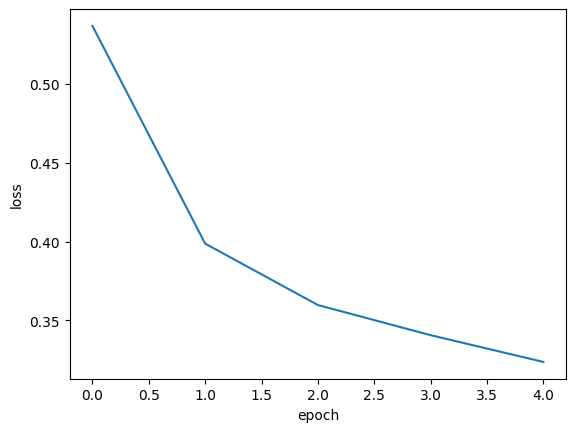

In [39]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

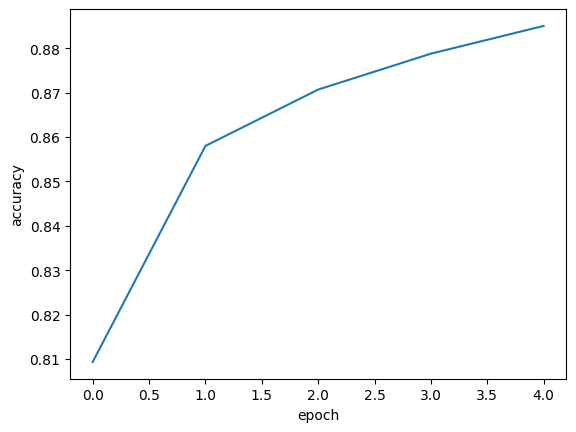

In [40]:
plt.plot(history.history['accuracy'])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## epoch를 늘리면?

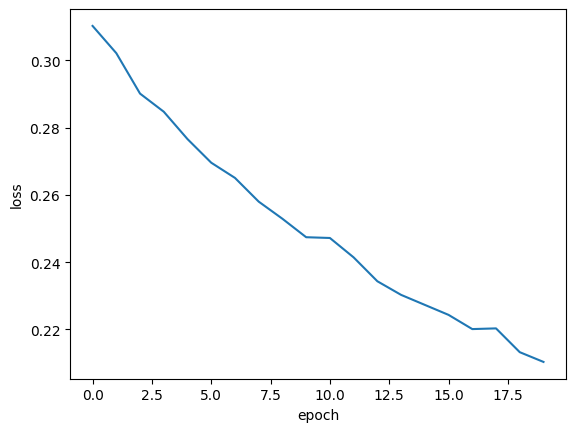

In [41]:
history=model.fit(x_train,y_train,epochs=20,verbose=0)
plt.plot(history.history['loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.show()

### epoch가 증가할수록 손실감소-> 그렇다면 더 좋은 모델인가?
# 3-2. 검증손실을 통한 과대/과소 적합
- 검증세트에 대한 손실 곡선도 필요

### fit안에 validation_data로 검증데이터 전달가능

In [45]:
model=model_fn()
model.compile(loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train,y_train,epochs=20,verbose=0,validation_data=(x_val,y_val))  #validate_data에 검증데이터 전달
history.history.keys()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

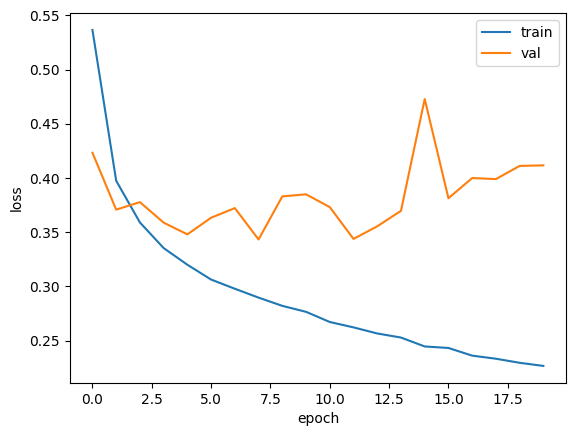

In [46]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

### epoch가 너무 과도하면 과대적합이 일어나고 검증 손실은 오히려 증가할 수 있음

## 옵티마이저를 사용해서 과대적합 완화해보기->adm

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


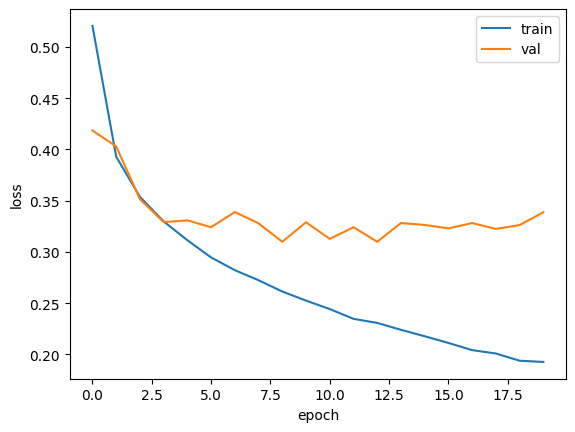

In [47]:
model=model_fn()
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train,y_train,epochs=20,verbose=0,validation_data=(x_val,y_val))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

### adam은 에포크가 진행되면서 학습률의 크기를 조정하기에 과대적합이 줄어듬->adam이 이 데이터셋에 잘맞음

# 3-3. 드롭아웃: 규제를 통해 과대적합 막음  
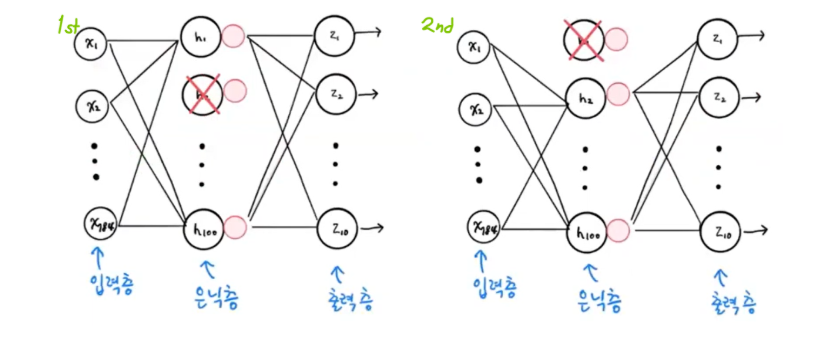
- 층에 있는 일부 뉴런을 랜덤하게 꺼서(출력을 0으로) 성능을 낮춤으로 과대적합 해결
- 드롭아웃의 또다른 관점: 2개의 신경망을 앙상블한것->과대적합 막음
- 얼마나 많은 뉴런을 드롭할지는 우리가 정해야 하는 파라미터

## keras.layers.Dropout(비율) 사용
- 어떤 층의 뒤에 드롭아웃을 두어 이 층의 출력을 랜덤하게 0으로

In [48]:
model=model_fn(keras.layers.Dropout(0.3)) # 30%정도를 드롭아웃
model.summary()  #dense7의 층에 100개의 뉴런중 랜덤하게 30%정도를 꺼버림

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_5 (Flatten)             │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 100)            │        78,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 10)             │         1,010 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,510 (310.59 KB)

 Trainable params: 79,510 (310.59 KB)

 Non-trainable params: 0 (0.00 B)

### 훈련이 끝난 뒤에는 드롭아웃 적용을 해제해야함(훈련된 모든 뉴런을 사용해야 올바른 예측이 가능함으로)
### -> 텐서플로우와 케라스는 똑똑하게 자동으로 훈련이후의 모델 평가나 예측할때 드롭아웃을 적용하지 않음

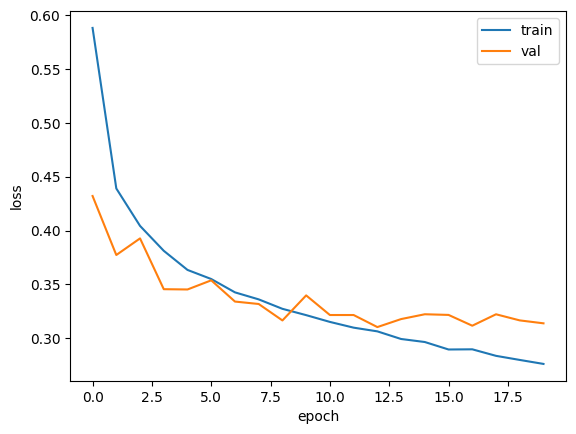

In [49]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train,y_train,epochs=20,verbose=0,validation_data=(x_val,y_val))

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.show()

## 과대적합이 확실히 줄음->epoch=10정도가 적당해보임

# 3-4. 모델 저장과 복원

In [51]:
# epoch=10으로
model=model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])
history=model.fit(x_train,y_train,epochs=10,verbose=0,validation_data=(x_val,y_val))

### 저장 방법
### model.save_weights(x.h5) ->모델의 가중치만 저장(훈련 이후의 가중치(coef_와 intecept_)까지만 저장)    
### model.save(x.h5) ->모델 구조와 모델 파라미터를 함께 저장(층, 가중치, 옵티마이저 설정, 손실함수, metrics까지 저장)
### HDF5라는 .h5 확장자로 저장
## history객체는 pickle로 저장하면 됨

In [53]:
model.save_weights('model-weights.weights.h5')   #weights.h5형태
model.save('model-whole.h5')   #.h5형태

In [54]:
!ls -al *.h5 # !:명령하겠다  ls:현재 dir 파일목록보기 -al:숨김파일포함 자세히 보기 *.h5:h5확장자인 파일들만

-rw-r--r-- 1 root root 976600 Apr 20 13:19 model-weights.weights.h5
-rw-r--r-- 1 root root 978584 Apr 20 13:19 model-whole.h5


# 불러오기
- save_weights는 load_weights로
- save는 load_model로

## load_weights()

In [56]:
# load_weights는 구조가 없으므로 처음 구조 지정 후 가중치 정보 불러오기(fit으로 학습 필요 X)
model=model_fn(keras.layers.Dropout(0.3))
model.load_weights('model-weights.weights.h5')

In [57]:
# predict해보기
val_labels=np.argmax(model.predict(x_val),axis=-1) # 최대값의 인덱스를 가져옴, axis=0은 밑으로, axis=1은 옆으로, axis=-1은 마지막 차원==axis=1과 동일
print(np.mean(val_labels==y_val))  #

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
0.8858333333333334


In [59]:
val_labels=np.argmax(model.predict(x_val),axis=1) # 최대값의 인덱스를 가져옴, axis=0은 밑으로 axis=1은 옆으로 axis=-1은 마지막 차원==axis
print(np.mean(val_labels==y_val))  # va_labels값은 최대확률을 갖는 값의 인덱스==클래스종류를 의미

375/375 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
0.8858333333333334


In [61]:
y_val[:10],val_labels[:10]  #결국 np.mean(val_labels==y_val)은 정확도 R^2을 의미

(array([6, 1, 8, 3, 7, 0, 0, 6, 0, 1], dtype=uint8),
 array([6, 1, 8, 3, 7, 0, 0, 0, 6, 1]))

## keras.models.load_model()

In [62]:
# 다가지고와서 바로 evaluate이나 predict하면 됨
model=keras.models.load_model('model-whole.h5')
model.evaluate(x_val,y_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.8904 - loss: 0.3108


[0.3229920566082001, 0.8858333230018616]

# 3-5. 콜백: 훈련과정 중간에 어떤 작업을 수행하게 해주는 객체
- keras.callbacks.ModelCheckpoint(): 가장 낮은 검증 손실을 만드는 모델을 저장
- keras.callbacks.EarlyStopping(): 과대 적합이 시작되기 전에 훈련을 미리 중지-검증 손실값을 기준으로
### 이 두 객체를 미리 설정하고 .fit의 callbacks에 리스트 형태로 넣어줌

In [64]:
model=model_fn(keras.layers.Dropout(0.3))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',metrics=['accuracy'])

checkpoint_cb=keras.callbacks.ModelCheckpoint('best-model.h5', save_best_only=True)  #모델 훈련 후에 제일좋은 모델 best-model.h5로 저장

early_stopping_cb=keras.callbacks.EarlyStopping(patience=2,restore_best_weights=True) #patience=2 검증점수 향상되지 않아도 2번 기다려줌

history=model.fit(x_train,y_train,epochs=20,verbose=0,validation_data=(x_val,y_val),
                  callbacks=[checkpoint_cb,early_stopping_cb])   # .fit에 callbacks옵션에 만들어 둔 객체 넣어줌

### best모델 가져오기

In [65]:
bestmodel=keras.models.load_model('best-model.h5')
model.evaluate(x_val,y_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8839 - loss: 0.3195


[0.33418869972229004, 0.8784166574478149]

### 어디서 멈췄는지 보기

In [66]:
early_stopping_cb.stopped_epoch

7

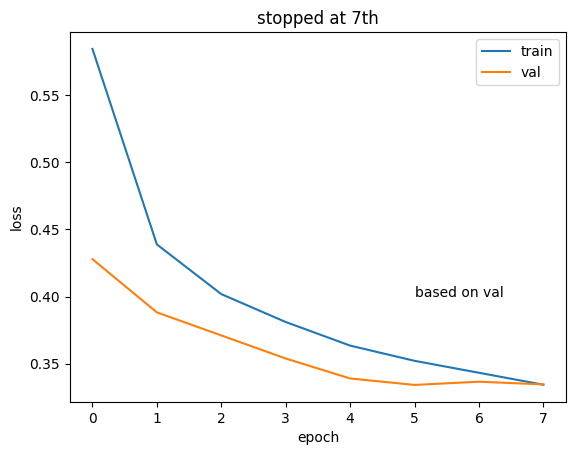

In [73]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','val'])
plt.title('stopped at 7th')
plt.text(5,0.4,'based on val')
plt.show()

## 마지막으로 확인

In [74]:
model.evaluate(x_val,y_val)

375/375 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8839 - loss: 0.3195


[0.33418869972229004, 0.8784166574478149]